# EBA3500 Lecture 9. Interaction

We'll use the `titanic` data set once again. 

In [13]:
import pyreadr, os, pathlib

def pyreadr_load(url, local_file = "temp_pyreadr.rda"):
  """Download the R dataset at the specified url into local_file, load the 
  local file, delete the local file. Return the dataset."""
  
  file_name = pyreadr.download_file(url, local_file)
  dataframe = pyreadr.read_r(file_name)
  os.remove(str(pathlib.Path().resolve()) + "/" + file_name)
  name = next(iter(dataframe.items()))[0]
  return dataframe[name]

In [14]:
url = 'https://github.com/kassambara/datarium/blob/master/data/titanic.raw.rda?raw=true'
titanic = pyreadr_load(url)
titanic.head()

,Class,Sex,Age,Survived
0,3rd,Male,Child,No
1,3rd,Male,Child,No
2,3rd,Male,Child,No
3,3rd,Male,Child,No
4,3rd,Male,Child,No


## Interactions

Interactions are regression terms that involve products of two or more covariates, e.g., 
$$y = \alpha + \beta_1 x_1 + \beta_{12} x_1x_2.$$ 
The terminology is most freqently used for categorical variables. Let's explore what it means.

## The Cartesian product

We'll have to deal with another fundamental set-theoretic construction, called the *Cartesian product*. 

**Note:** If something is *Cartesian*, it is named after the French reneissance philosopher René Descartes.

We will use the symbol "$\in$", which reads reads "in". Writing "$a\in A$" means the same as "$a \textrm{ in } A$". This symbol may look unfamiliar but is a staple of mathematical notation.

#### Definition
> Let $A$ and $B$ be two sets. The *Cartesian product*, denoted by $A\times B$, is the unique set containing the tuples $(a,b)$ for $a\in A$ and $b \in B$. 

We also call $A \times B$ the *product set*, or the product of $A$ and $B$. 

#### Example

Recall the sex and class categories from the Titanic data set.

In [15]:
set(titanic.Sex)

{'Female', 'Male'}

In [16]:
set(titanic.Class)

{'1st', '2nd', '3rd', 'Crew'}

We will construct the product set of these two sets. To to this, we will use the `product` function from `itertools`. This function often comes in handy in programming in general.

In [17]:
from itertools import product
set(product(set(titanic.Sex), set(titanic.Class)))

{('Female', '1st'),
 ('Female', '2nd'),
 ('Female', '3rd'),
 ('Female', 'Crew'),
 ('Male', '1st'),
 ('Male', '2nd'),
 ('Male', '3rd'),
 ('Male', 'Crew')}

We can also take the product of more than two sets, say $A\times B \times C$. Such products are defined in the obvious way, i.e., $(a,b,c)\in A\times B\times C$ if and only if $a\in A$, $b \in B$, and $c \in C$.

In [18]:
set(titanic.Age)

{'Adult', 'Child'}

In [19]:
set(product(set(titanic.Sex), set(titanic.Class), set(titanic.Age)))

{('Female', '1st', 'Adult'),
 ('Female', '1st', 'Child'),
 ('Female', '2nd', 'Adult'),
 ('Female', '2nd', 'Child'),
 ('Female', '3rd', 'Adult'),
 ('Female', '3rd', 'Child'),
 ('Female', 'Crew', 'Adult'),
 ('Female', 'Crew', 'Child'),
 ('Male', '1st', 'Adult'),
 ('Male', '1st', 'Child'),
 ('Male', '2nd', 'Adult'),
 ('Male', '2nd', 'Child'),
 ('Male', '3rd', 'Adult'),
 ('Male', '3rd', 'Child'),
 ('Male', 'Crew', 'Adult'),
 ('Male', 'Crew', 'Child')}

### Titanic and interaction


Recall from the last lecture that both sex and class affects the probability of survival. 

<AxesSubplot:xlabel='Class', ylabel='count'>

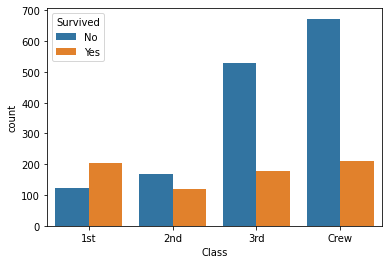

In [20]:
import seaborn as sns
sns.countplot(x="Class", hue="Survived", data=titanic)

The basic model involves only *linear effects*
$$
y = \beta_0 + \beta_{\textrm{male}}1[\textrm{sex} = \textrm{male}] + \beta_{\textrm{2nd}}1[\textrm{class} = \textrm{2nd}]+ \beta_{\textrm{3rd}}1[\textrm{class} = \textrm{3rd}] + \beta_{\textrm{Crew}}1[\textrm{class} = \textrm{crew}].
$$



Let's fit it and see what we get.

In [26]:
import statsmodels.formula.api as smf
titanic["Survived_01"] = 1 * (titanic.Survived == "Yes")
fit = smf.ols("Survived_01 ~ Sex + Class", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     179.4
Date:                Wed, 20 Oct 2021   Prob (F-statistic):          4.09e-133
Time:                        17:40:25   Log-Likelihood:                -1139.0
No. Observations:                2201   AIC:                             2288.
Df Residuals:                    2196   BIC:                             2317.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9001      0.026     34.739      0.000       0.849       0.951
Sex[T.Male]      -0.4974      0.023    -21.575      0.000      -0.543      -0.452
Class[T.2nd]     -0.1737      0.033     -5.258      0.000      -0.238      -0.109
Class[T.3rd]     -0.2887      0.028    -10.489      0.000      -0.343      -0.235
Class[T.Crew]    -0.1761      0.028     -6.270      0.000      -0.231      -0.121
==============================================================================
Omnibus:                      222.654   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              293.437
Skew:                           0.891   Prob(JB):                     1.91e-64
Kurtosis:                       2.836   Cond. No.                         7.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we check how well the estimates match the data. First we'll take a look at the predicted values of the model.

In [27]:
import pandas as pd
records = sorted(list(product(set(titanic.Sex), set(titanic.Class))))
records

[('Female', '1st'),
 ('Female', '2nd'),
 ('Female', '3rd'),
 ('Female', 'Crew'),
 ('Male', '1st'),
 ('Male', '2nd'),
 ('Male', '3rd'),
 ('Male', 'Crew')]

In [28]:
frame = pd.DataFrame.from_records(records, columns = ["Sex", "Class"])
fit.predict(frame)

0    0.900080
1    0.726416
2    0.611412
3    0.723988
4    0.402714
5    0.229050
6    0.114046
7    0.226622
dtype: float64

This is just a list of floats with no names. Let's merge it with the `frame` to make stuff clearer

In [29]:
frame["Predicted"] = fit.predict(frame)
frame

,Sex,Class,Predicted
0,Female,1st,0.900080
1,Female,2nd,0.726416
2,Female,3rd,0.611412
3,Female,Crew,0.723988
4,Male,1st,0.402714
5,Male,2nd,0.229050
6,Male,3rd,0.114046
7,Male,Crew,0.226622


Let's compare these predictions to the means using the `groupby` method.

In [30]:
titanic["Survived_01"] = 1 * (titanic.Survived == "Yes")

In [31]:
means = titanic.groupby(["Sex", "Class"]).mean()["Survived_01"]
means

Sex     Class
Female  1st      0.972414
        2nd      0.877358
        3rd      0.459184
        Crew     0.869565
Male    1st      0.344444
        2nd      0.139665
        3rd      0.172549
        Crew     0.222738
Name: Survived_01, dtype: float64

This table is simple enough. The mean on the column to the right is the mean of the subgroup for the corresponding sex and class on the right.

Let's compare these means to the predicted values of our model.

In [ ]:
import numpy as np
frame["Mean"] = means.array
frame

,Sex,Class,Mean
0,Female,1st,0.972414
1,Female,2nd,0.877358
2,Female,3rd,0.459184
3,Female,Crew,0.869565
4,Male,1st,0.344444
5,Male,2nd,0.139665
6,Male,3rd,0.172549
7,Male,Crew,0.222738


Why aren't the values equal? First, notice that there are $8$ means, but only $5$ parameters in the regression output. Second, the model doens't take *interactions* into account, only linear effects. Interactions occur when the effect of one variable depends on the value of another variable.


### A "two-way" model

Let $A$ and $B$ be sets with $I$ and $J$ elements each. Consider the following model
$$y=\sum_{i=1}^{I}\sum_{j=1}^{J}\beta_{ij}1[X_{1}=a_{j}]1[X_{2}=b_{k}].$$
That is the same model as 
$$y=\sum_{i=1}^{I}\sum_{j=1}^{J}\beta_{ij}1[X = (a_{j}, b_{k})],$$
where $(a_i,b_j) \in A\times B$. Thus it may be viewed as an ordinary categorical variable model.

### Titanic example

Let $A = \{\textrm{female}, \textrm{male}\}$ and $B = \{\textrm{2nd},\textrm{3rd}, \textrm{3rd}, \textrm{Crew}\}$. That is, $A$ are the sex categories and $B$ are the class categories. Remember their product set, which equals


In [ ]:
set(product(set(titanic.Sex), set(titanic.Class)))

{('Female', '1st'),
 ('Female', '2nd'),
 ('Female', '3rd'),
 ('Female', 'Crew'),
 ('Male', '1st'),
 ('Male', '2nd'),
 ('Male', '3rd'),
 ('Male', 'Crew')}

Writing down the model explicitly doesn't help, as it's cumbersome to look at. But using $$y=\sum_{i=1}^{I}\sum_{j=1}^{J}\beta_{ij}1[X = (a_{j}, b_{k})],$$
where $(a_i,b_j) \in A\times B$, we can write a table of the corresponding coefficients.

|         |        | Class |     |     |      |
| ---     |------- | ----- | --- |-----| ---  |
|         |        | 1st   | 2nd | 3rd | Crew |
| **Sex** |        |       |     |     |      |
|         | Female | $\beta_{11}$ | $\beta_{12}$ | $\beta_{13}$ | $\beta_{14}$     |
|         | Male   | $\beta_{21}$ | $\beta_{22}$ | $\beta_{23}$ | $\beta_{24}$     |

When you want to predict the probability of survival for a male passenger traveling 3rd class, you find the second row (male) and third column (3rd class), and use the $\beta_{23}$ coefficient. 

Now let's fit the model! To do this, we will define a new column in the data frame `titanic` containing the product set of `Sex` and `Class`.

In [ ]:
titanic["SexClass"] = list(zip(titanic["Sex"], titanic["Class"]))
titanic.SexClass

0          (Male, 3rd)
1          (Male, 3rd)
2          (Male, 3rd)
3          (Male, 3rd)
4          (Male, 3rd)
             ...      
2196    (Female, Crew)
2197    (Female, Crew)
2198    (Female, Crew)
2199    (Female, Crew)
2200    (Female, Crew)
Name: SexClass, Length: 2201, dtype: object

Now we're ready to run the model.

In [ ]:
fit = smf.ols("Survived_01 ~ SexClass - 1", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     116.6
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          1.01e-145
Time:                        05:27:26   Log-Likelihood:                -1102.0
No. Observations:                2201   AIC:                             2220.
Df Residuals:                    2193   BIC:                             2266.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
SexClass[('Female', '1st')]      0.9724      0.033     29.278      0.000       0.907       1.038
SexClass[('Female', '2nd')]      0.8774      0.039     22.586      0.000       0.801       0.954
SexClass[('Female', '3rd')]      0.4592      0.029     16.074      0.000       0.403       0.515
SexClass[('Female', 'Crew')]     0.8696      0.083     10.427      0.000       0.706       1.033
SexClass[('Male', '1st')]        0.3444      0.030     11.555      0.000       0.286       0.403
SexClass[('Male', '2nd')]        0.1397      0.030      4.672      0.000       0.081       0.198
SexClass[('Male', '3rd')]        0.1725      0.018      9.743      0.000       0.138       0.207
SexClass[('Male', 'Crew')]       0.2227      0.014     16.351      0.000       0.196       0.249
==============================================================================
Omnibus:                      286.377   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.796
Skew:                           1.059   Prob(JB):                     3.80e-90
Kurtosis:                       2.963   Cond. No.                         6.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see how these new coefficients match the means we just calculated.

In [ ]:
frame["NewPredicted"] = fit.params.array
frame

,Sex,Class,Predicted,Mean,NewPredicted
0,Female,1st,0.900080,0.972414,0.972414
1,Female,2nd,0.726416,0.877358,0.877358
2,Female,3rd,0.611412,0.459184,0.459184
3,Female,Crew,0.723988,0.869565,0.869565
4,Male,1st,0.402714,0.344444,0.344444
5,Male,2nd,0.229050,0.139665,0.139665
6,Male,3rd,0.114046,0.172549,0.172549
7,Male,Crew,0.226622,0.222738,0.222738


That's perfect!

As it happens, `statsmodels` allows us to run interaction models such as these easily. We just need to use the `*` command:

In [ ]:
import statsmodels.formula.api as smf
fit = smf.ols("Survived_01 ~ Sex * Class", data = titanic).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Survived_01   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     116.6
Date:                Thu, 14 Oct 2021   Prob (F-statistic):          1.01e-145
Time:                        05:37:30   Log-Likelihood:                -1102.0
No. Observations:                2201   AIC:                             2220.
Df Residuals:                    2193   BIC:                             2266.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.9724      0.033     29.278      0.000       0.907       1.038
Sex[T.Male]                  -0.6280      0.045    -14.071      0.000      -0.715      -0.540
Class[T.2nd]                 -0.0951      0.051     -1.860      0.063      -0.195       0.005
Class[T.3rd]                 -0.5132      0.044    -11.715      0.000      -0.599      -0.427
Class[T.Crew]                -0.1028      0.090     -1.146      0.252      -0.279       0.073
Sex[T.Male]:Class[T.2nd]     -0.1097      0.066     -1.655      0.098      -0.240       0.020
Sex[T.Male]:Class[T.3rd]      0.3413      0.056      6.109      0.000       0.232       0.451
Sex[T.Male]:Class[T.Crew]    -0.0189      0.096     -0.197      0.844      -0.206       0.169
==============================================================================
Omnibus:                      286.377   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.796
Skew:                           1.059   Prob(JB):                     3.80e-90
Kurtosis:                       2.963   Cond. No.                         24.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Yet again, we have to think about baselines. Since there is no `Sex[T.Female]` in the table, the baseline sex is female. Since there is no `Class[T.1st]` in the table, the baseline class if 1st class.

To calculate the predicted value of, say, a male with class `3rd`, you would have to sum the coefficients of `Sex[T.Male]`, `Class[T.3rd]` *and* `Sex[T.Male]:Class[T.3rd]`. 

In [ ]:
fit.params

Intercept                    0.972414
Sex[T.Male]                 -0.627969
Class[T.2nd]                -0.095055
Class[T.3rd]                -0.513230
Class[T.Crew]               -0.102849
Sex[T.Male]:Class[T.2nd]    -0.109724
Sex[T.Male]:Class[T.3rd]     0.341335
Sex[T.Male]:Class[T.Crew]   -0.018858
dtype: float64

In [ ]:
coef = fit.params
coef["Intercept"] + coef["Sex[T.Male]"] + coef["Class[T.3rd]"]+ coef["Sex[T.Male]:Class[T.3rd]"]

0.17254901960784796

In [ ]:
frame[6:7]

,Sex,Class,Predicted,Mean,NewPredicted
6,Male,3rd,0.114046,0.172549,0.172549


It's clearly harder to interpret the coefficients of a the `statsmodels` object with formula `"Survived_01 ~ Sex * Class"` than that with formula `"Survived_01 ~ SexClass - 1"`. However, we may use the formulation `"Survived_01 ~ Sex * Class"` to more easily ask meaningful questions.




Most importantly, do we need the interaction terms or not? In other words, do we need the whole model `"Survived_01 ~ Sex * Class"`, or would it suffice with `"Survived_01 ~ Sex + Class"`?

## Testing for interactions

Testing for interactions is similar to the testing we did in the last lecture. Consider a model with $2$ categorical variables $x_1$ and $x_2$ with $I$ and $J$ categories each. The model with linear effects is 
$$
y = \beta_0 + \sum_{i = 2}^{I} {\beta^1_{i}1[x_1 = i]} + \sum_{j = 2}^{J} {\beta^2_{j} 1[x_2 = j]} + \epsilon
$$

Here we start the sums at $i=2$ and $j=2$ since the $x_1 = 1$ and $x_2 = 2$ are absorbed into the baseline.

This is the general form of the titanic model with two categories we've already looked at:

In [ ]:
import statsmodels.formula.api as smf
titanic["Survived_01"] = 1 * (titanic.Survived == "Yes")
fit = smf.ols("Survived_01 ~ Sex + Class", data = titanic).fit()
fit.summary()

This model doesn't include interactions, as there are no product terms `1[x_1 = i]1[x_2 = j]` in the model. Let's add them to the model and see what it looks like.

The interaction model can be written as en extension of the linear effects model
$$
y = \beta_0 + \sum_{i = 2}^{I} {\beta^1_{i}1[x_1 = i]} + \sum_{j = 2}^{J} {\beta^2_{j} 1[x_2 = j]} + \sum_{i = 2}^{I}\sum_{j = 2}^{J} {\beta^{1\times2}_{ij} 1[x_1 = j]1[x_2=j]} + \epsilon
$$

The double sum starts at $i,j=2$ due to absorption into the baseline.

Formulating the interaction model in this way allows us to formulate a test of whether the interactions matter. Our null hypothesis is that the all the regression coefficients belonging to the interaction part of the model are $0$. Formally, we could write
$$H_0: \beta^{1\times2}_{ij} = 0\quad \textrm{for all } i,j\geq2.$$
Our alternative hypothesis is that the interaction terms matter *in some way*. In other words, at least one coefficients $\beta^{1\times2}_{ij}$ is not equal to $0$.
$$H_a: \textrm{There is a pair } (i,j) \textrm{ where } \beta^{1\times2}_{ij} \neq 0.$$

This is similar to the setup in the previous lecture, except that we care about a *subset* of $\beta$s, not all of them. We can still test using a similar setup, but to discuss this properly we need to introduce a new concept, that of partial $R^2$.

## Partial $R^2$

Remember the definition of least squares regression. We have a bunch of covariates $x_1,...,x_k$ and a response $y$. To predict the value of $y$, we find the vector $\beta$ that minimizes the squared error distance between $y$ and $\beta_0 + \sum_{k=1}^{K} \beta_{k} x_{k}$. In other words, we find the $\beta$ that minimize
$$\sum_{i=1}^{n}\left(y_{i}-[\beta_{0}+\sum_{k=1}^{K}\beta_{k}x_{ki}]\right)^{2}.$$



Recall that we denote the vector $\beta$ that minimizes this sum of squares by $\hat{\beta}$, so that the minimal sum of squares equals 

$$
\sum_{i=1}^{n}\left(y_{i}-[\hat{\beta}_{0}+\sum_{k=1}^{K}\hat{\beta}_{k}x_{ki}]\right)^{2}.
$$


An alternative way of writing the minimal sum of squares is to use the `min` operator, which finds the minimum of the expression to its right. In our case, we find that 
$$\min_\beta \sum_{i=1}^{n}\left(y_{i}-[\beta_{0}+\sum_{k=1}^{K}\beta_{k}x_{ki}]\right)^{2} = \sum_{i=1}^{n}\left(y_{i}-[\hat{\beta}_{0}+\sum_{k=1}^{K}\hat{\beta}_{k}x_{ki}]\right)^2.

We're going through all of this right now because we will have to compare the sum of squares for different regression models.

### Defining the partial $R^2$

Recall the formula for the $R^2$. Let $y = \beta_0 + \sum_{k=1}^{K} \beta_kx_k + \epsilon$ be a regression model. Then the $R^2$ is 

$$
R^2 = 1-\frac{\sum_{i=1}^{n}\left(y_{i}-[\hat{\beta}_{0}+\sum_{k=1}^{K}\hat{\beta}_{k}x_{ki}]\right)^{2}}{\sum_{i=1}^{n}(y_{i}-\overline{y})^{2}}.
$$

This $R^2$ compares the predictive power of using all the available covariates, $\beta_0 + \sum_{k=1}^{K} \hat{\beta_k}x_k$, to using none of all. To see why, observe that the denominator involves the mean $\overline{y}$ since it is the best possible prediction of $y$, in the least squares sense, given no additional covariates. We may write

$$
R^2 = 1-\frac{\min_\beta\sum_{i=1}^{n}\left(y_{i}-[{\beta}_{0}+\sum_{k=1}^{K}{\beta}_{k}x_{ki}]\right)^{2}}{\min_\beta\sum_{i=1}^{n}(y_{i}-\beta_0)^{2}}.
$$

A *partial $R^2$* compares the predictive power of using all covariates to using just a few of them. 
Let's consider the model $$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon.$$
There are three partial $R^2\textrm{s}$ in this model. The first compares the regression with both $x_1,x_2$ to the regression with only $x_1$:
$$
R_p^2 = 1-\frac{\min_\beta \sum_{i=1}^{n}\left(y_{i}-[{\beta}_{0}+{\beta}_{1}x_{1i}+{\beta}_{2}x_{2i}]\right)^{2}}{\min_\beta\sum_{i=1}^{n}(y_{i}-[{\beta}_{0}+{\beta}_{1}x_{1i}])^{2}}.
$$

The second compares the regression with both $x_1,x_2$ to the regression with only $x_2$:
$$
R_p^2 = 1-\frac{\min_\beta \sum_{i=1}^{n}\left(y_{i}-[{\beta}_{0}+{\beta}_{1}x_{1i}+{\beta}_{2}x_{2i}]\right)^{2}}{\min_\beta\sum_{i=1}^{n}(y_{i}-[{\beta}_{0}+{\beta}_{2}x_{2i}])^{2}}.
$$

And the final compares the regression with both $x_1,x_2$ to the regression with no covariates at all, which is the usual $R^2$.

This notion of partial $R^2$ can be generalized to larger regression models and any *subset* of the covariates $x_1, x_2, ..., x_k$. 

### Definition: Subset
> Let $A$ be a set. Then $B$ is a subset of $A$, denoted $B \subseteq A$, if and only if every member of $B$ is a member of $A$,

For instance, $B = \{1,2\}$ is a subset of $A=\{1,2,3\}$, as both members of $B$, $1$ and $2$, are members of $A$ too. The set $C = \{1,2, 4\}$ is not a subset of $A$, as $4$ is not a member of $A$.

### Definition: Partial $R^2$
> Let $y = \beta_0 + \sum_{k=1}^{K} \beta_kx_k + \epsilon$ be a regression model with $K$ covariates and let $J\subset K$ be a subset of $K$. Then the partial $R^2$ of $J$ is 
> $$
R_p^2 = 1-\frac{\min_\beta\sum_{i=1}^{n}\left(y_{i}-[\beta_{0}+\sum_{k=1}^{K}\beta_{k}x_{k}]\right)^{2}}{\min_\beta\sum_{i=1}^{n}(y_{i}-[\beta_{0}+\sum_{j \in J}\beta_{j}x_{j}])^{2}}.
$$

### Connecting the partial $R^2$ to interactions

Let's go back to the problem of testing for interactions! The model with linear effects is 
$$
y = \beta_0 + \sum_{i = 2}^{I} {\beta^1_{i}1[x_1 = i]} + \sum_{j = 2}^{J} {\beta^2_{j} 1[x_2 = j]} + \epsilon.
$$


And the model with interactions is
$$
y = \beta_0 + \sum_{i = 2}^{I} {\beta^1_{i}1[x_1 = i]} + \sum_{j = 2}^{J} {\beta^2_{j} 1[x_2 = j]} + \sum_{i = 2}^{I}\sum_{j = 2}^{J} {\beta^{1\times2}_{ij} 1[x_1 = j]1[x_2=j]} + \epsilon
$$

Now consider the partial $R^2$ of the interaction model vs the linear effects model.
$$
R_p^2 = 1-\frac{\min_\beta\sum_{i=1}^{n}(y_{i}-[\beta_0 + \sum_{i = 2}^{I} {\beta^1_{i}1[x_1 = i]} + \sum_{j = 2}^{J} {\beta^2_{j} 1[x_2 = j]} + \sum_{i = 2}^{I}\sum_{j = 2}^{J} {\beta^{1\times2}_{ij} 1[x_1 = j]1[x_2=j]}])^{2}}{\min_\beta\sum_{i=1}^{n}\left(y_{i}-[\beta_0 + \sum_{i = 2}^{I} {\beta^1_{i}1[x_1 = i]} + \sum_{j = 2}^{J} {\beta^2_{j} 1[x_2 = j]}]\right)^{2}}.
$$

This expression looks complicated, but it's not too bad. The bottom model involves only the linear effects, the top model involves both the linear effects and the interaction effects. 

1. **What does this partial $R^2$ quantify?** 
   - It quantifies how much better we can predict $y$ using the interaction model compared to the linear effects model.
2. **When is the population partial $R^2$ equal to $0$?** 
   - It equals $0$ if all the interaction terms $\beta^{1\times2}_{ij}$ are 0.

We can use this to construct a test of $H_0$ vs $H_a$ in the same way as in the last lecture by deducing the distribution of $R^2_p$. However, we will look at the distribution of a certain $F$ value instead of $R_p^2$, as this is what's usually done. 

As we discussed in the previous lecture, we will look at the $F$ value instead of the $R^2$. 

## Summary
1. We can test if at least one of the coefficients $\beta \neq 0$ using the $F$-test.
2. Using the $F$-test is equivalent to testing if the $R^2$ is greater than $0$.
3. Interactions is the statistical term for a model involving products of two or more variables $x_1,x_2$, e.g. $y = \beta x_1 + \beta_{12} x_1 x_2$.